In [25]:
library(tidyverse)
library(igraph)

In [26]:
nodes = read.csv('../datasets/wits/nl_no_missing.csv')
edges = read.csv('../datasets/wits/el_no_missing.csv')

In [27]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,NPL,LBR,97.061
2,NPL,AZE,46.502
3,NPL,JOR,25.551


In [28]:
head(nodes, 3)

,country_iso3,gdp_us_dollar,inflation_rate,gdp_growth,colonizer,area,landlocked,continent,langoff_1,population,gdp_per_capita,life_expectancy,gni_atlas,agriculture_forestry_fishing_of_gdp,industry_of_gdp,merchandise_of_gdp,net_barter_of_trade,foreign_direct_investment_inflows,happiness
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,17804292964,11.804186,0.4263548,USA,652225,1,Asia,Persian,30117411,591.1628,61.553,16077121256,23.743664,22.74025,38.70415,144.7519,52173421,0.721
2,AGO,111789686464,13.482468,3.4719763,PRT,1246700,0,Africa,Portuguese,24220660,4615.4682,56.330,82606027251,5.845681,56.02651,78.30597,244.3292,-3023770966,0.708
3,ALB,12890765324,3.429123,2.5453218,NONE,28748,0,Europe,Albanian,2905195,4437.1429,76.914,12803715190,18.226765,24.48441,56.86241,94.3372,1048706682,0.568


In [29]:
n = dim(nodes)[1]
N = 1000
country_names = nodes$country_iso3
nodes = transform(nodes, landlocked=as.logical(landlocked))

In [30]:
trade_graph = igraph::graph_from_edgelist(as.matrix(edges[, c("source", "target")]), directed = T) %>%
    igraph::set_edge_attr(name = "weight", value = edges$weight)

In [31]:
btwn_centrality = betweenness(trade_graph)

In [32]:
eigen_centrality = evcent(trade_graph)$vector

In [33]:
degree_centrality = degree(trade_graph, mode = 'out')

In [34]:
hubs = hub_score(trade_graph)$vector

In [35]:
authorities = authority_score(trade_graph)$vector

In [36]:
centralities_data_frame = data.frame(
    name = names(btwn_centrality), 
    btwn_centrality = btwn_centrality, 
    eigen_centrality = eigen_centrality, 
    degree_centrality = degree_centrality, 
    hubs_centrality = hubs, 
    authority_centrality = authorities
)

In [37]:
head(centralities_data_frame, 3)

,name,btwn_centrality,eigen_centrality,degree_centrality,hubs_centrality,authority_centrality
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NPL,NPL,2718.5,0.001341521,111,3.489081e-04,0.001726699
LBR,LBR,0.0,0.006823909,0,3.582447e-17,0.009655128
AZE,AZE,506.0,0.007870434,91,1.055237e-02,0.002783460


In [38]:
country_names = attr(centralities_data_frame, 'row.names')
centralities = c('btwn_centrality', 'eigen_centrality', 'degree_centrality', 'hubs_centrality', 'authority_centrality')
max_centralities = data.frame()
for (col in centralities) {
    max_centrality_index = which(centralities_data_frame[, col] == max(centralities_data_frame[, col]))
    max_centralities = max_centralities %>% 
        dplyr::bind_rows(
            data.frame(
                country = country_names[max_centrality_index], 
                centrality = col, 
                centrality_score = centralities_data_frame[max_centrality_index, col]
            )
        )
}

In [39]:
max_centralities

country,centrality,centrality_score
<chr>,<chr>,<dbl>
BIH,btwn_centrality,4885
USA,eigen_centrality,1
IRL,degree_centrality,141
CHN,hubs_centrality,1
USA,authority_centrality,1


In [40]:
nodes = merge(
    x = nodes, 
    y = centralities_data_frame, 
    by.x = 'country_iso3', 
    by.y = 'name'
)

In [41]:
values = log(nodes[, 'gdp_us_dollar'])
breaks <- c(quantile(values)[1] - 1, quantile(values)[3], quantile(values)[5] + 1)
tags <- c("Low", "High")
nodes[, 'gdp_us_dollar_levelized'] = cut(values, breaks = breaks, labels = tags)

In [42]:
observed_wilcox = wilcox.test(eigen_centrality ~ gdp_us_dollar_levelized, data = nodes)
observed_wilcox_statistic = observed_wilcox$statistic

In [43]:
permutated_wilcox_statistics = matrix(0, nrow = N)
for (i in 1:N) {
    permutated_wilcox_statistics[i] = wilcox.test(
        nodes$eigen_centrality ~ sample(
            nodes$gdp_us_dollar_levelized, 
            size = n, 
            replace = F
        )
    )$statistic
}

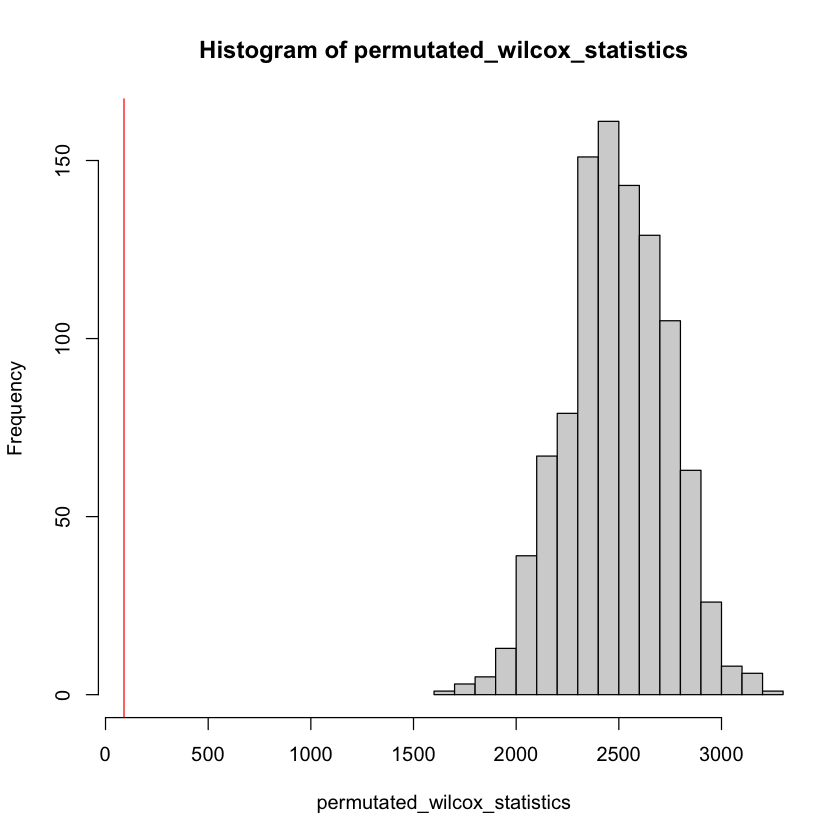

In [85]:
par(bg = 'white')
hist(permutated_wilcox_statistics, xlim = c(
    min(min(permutated_wilcox_statistics), observed_wilcox_statistic),
    max(max(permutated_wilcox_statistics), observed_wilcox_statistic)
))
abline(v = observed_wilcox_statistic, col = 'red')

In [87]:
library(MASS)

In [88]:
write.matrix(x = permutated_wilcox_statistics, './permutated_wilcox_statistics.txt', sep = '\n')

In [89]:
observed_wilcox_statistic

W 
90